In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
# build the vocabulary of characters and mappings to/from integers encoder & decoder
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [ ]:
# build the dataset
block_size = 3 # gram size
X, Y = [], []

for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [ ]:
C = torch.randn((27, 2)) # creates a embedding layer of dimension 2

In [ ]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [ ]:
emb

tensor([[[ 1.3310, -0.3722],
         [ 1.3310, -0.3722],
         [ 1.3310, -0.3722]],

        [[ 1.3310, -0.3722],
         [ 1.3310, -0.3722],
         [ 0.0714, -1.0709]],

        [[ 1.3310, -0.3722],
         [ 0.0714, -1.0709],
         [-1.4717, -0.0140]],

        [[ 0.0714, -1.0709],
         [-1.4717, -0.0140],
         [-1.4717, -0.0140]],

        [[-1.4717, -0.0140],
         [-1.4717, -0.0140],
         [-0.2922,  0.2748]],

        [[ 1.3310, -0.3722],
         [ 1.3310, -0.3722],
         [ 1.3310, -0.3722]],

        [[ 1.3310, -0.3722],
         [ 1.3310, -0.3722],
         [ 0.8882,  1.4720]],

        [[ 1.3310, -0.3722],
         [ 0.8882,  1.4720],
         [-1.2755,  0.0906]],

        [[ 0.8882,  1.4720],
         [-1.2755,  0.0906],
         [ 0.1149, -0.3840]],

        [[-1.2755,  0.0906],
         [ 0.1149, -0.3840],
         [ 0.2184, -1.1244]],

        [[ 0.1149, -0.3840],
         [ 0.2184, -1.1244],
         [ 0.1149, -0.3840]],

        [[ 0.2184, -1

In [ ]:
# since the emb shape is 32,3,2 and we need a input thats of dimension 32,6 we need to reshape or concat the inputs

In [ ]:
# version 1
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [ ]:
# version 2
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [ ]:
# version 3 (we use .view as its efficient)
# emb.view(32, 6)
emb.view(-1, 6).shape

torch.Size([32, 6])

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [ ]:
h.shape

torch.Size([32, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([32, 27])

In [ ]:
# softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(20.1459)

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g) # embedding layer
W1 = torch.randn((6, 100), generator=g) # weights
b1 = torch.randn(100, generator=g) # bias
W2 = torch.randn((100, 27), generator=g) # weights
b2 = torch.randn(27, generator=g) # bias
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for k in range(1000): # epoch

  # forward pass
  emb = C[X] # embedded layer
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # first hidden layer with activation
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Y) # loss

  # backward pass
  for p in parameters:
    p.grad = None # re intializing grad to none or zero
  loss.backward() # back-prop

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loss.item())

0.2561509907245636


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs # learning rate

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.162076473236084


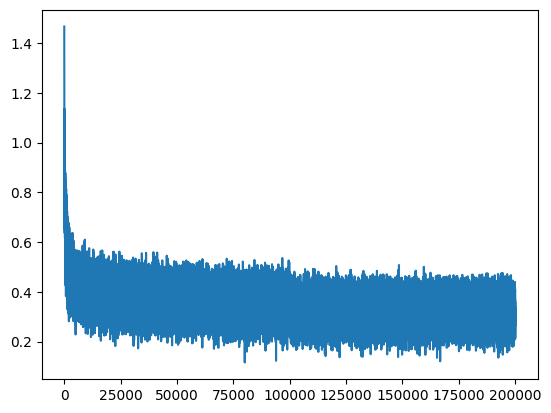

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1707, grad_fn=<NllLossBackward0>)

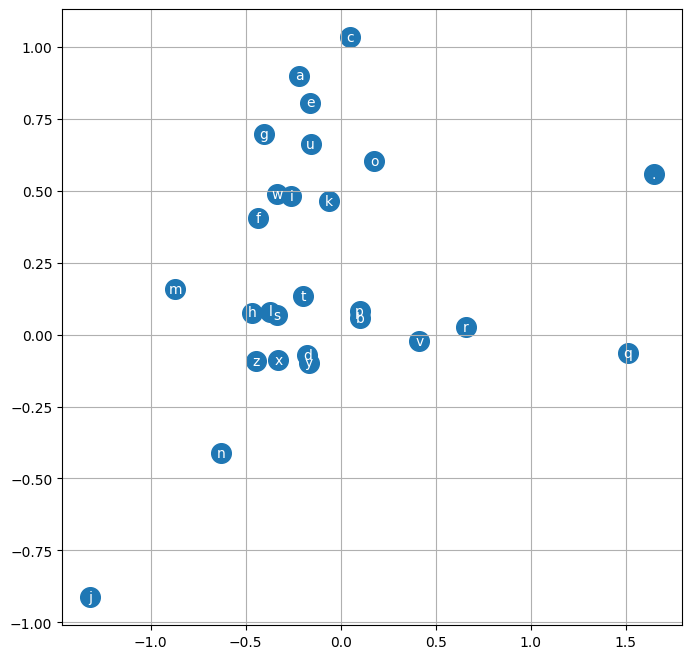

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mohaaymynn.
keel.
nihayah.
remmastendraeg.
adelynnelin.
shi.
jenleigh.
vananaraelynn.
hona.
cayshabergihamiel.
kinleenellennie.
cayus.
kaven.
kylynn.
els.
kaysh.
skylah.
hal.
aadyansyn.
zakhlee.
